<a href="https://colab.research.google.com/github/bingsen-wang/Electric-Machines/blob/main/Simulation_InductionMachine_StRF_complexVector_anim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b>Simulation: Induction Machine in Stationary Reference Frame</h1></b>

Dr. Bingsen Wang

7/12/2025
</center>

In stationary reference frame, the dynamic equations in matrix form are
In matrix form, (22) is rewritten as
$$
\left[\begin{array}{cc}L_s & L_m \\ L_m & L_r\end{array}\right]
\begin{bmatrix}{d\underline i_s\over dt}\\ {d\underline i_r\over dt}\end{bmatrix}
= \begin{bmatrix}-R_s & 0\\
j\omega_r L_m & -R_r +j\omega_r L_r\end{bmatrix}
\begin{bmatrix}\underline i_s\\
\underline i_r\end{bmatrix}
+ \begin{bmatrix}\underline v_s\\ \underline v_r\end{bmatrix}
\tag{1}$$

#Python Code

0
0
100
200
300
400
500
600
700
0


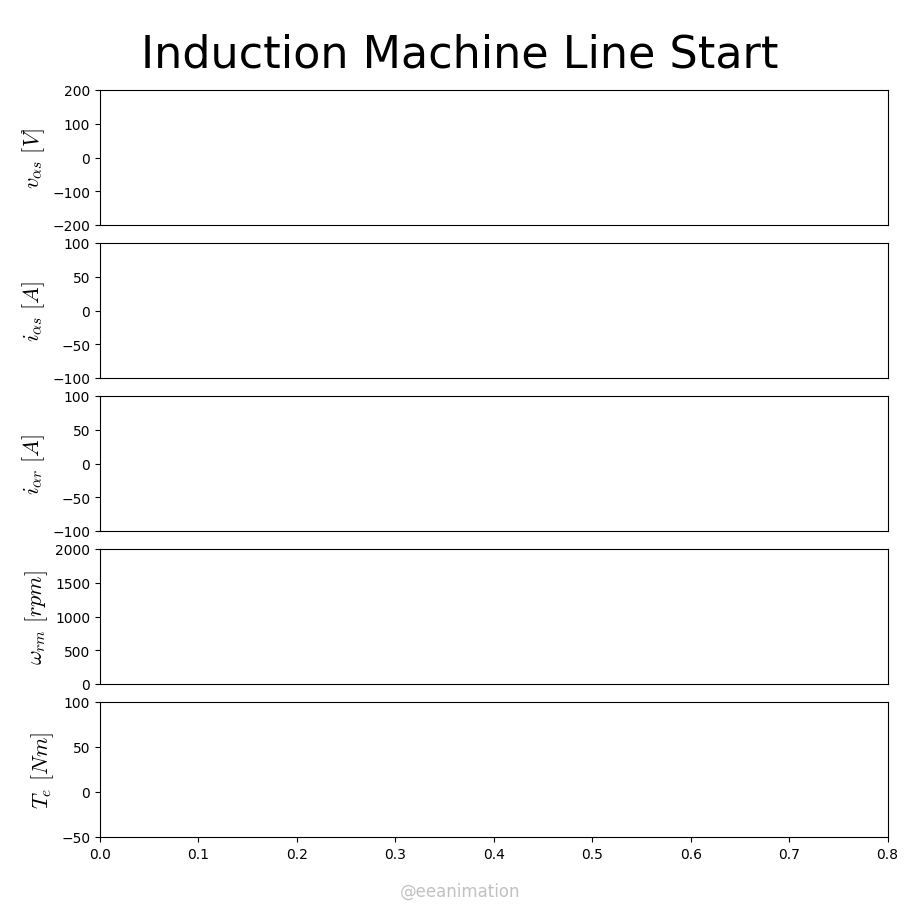

In [27]:
from matplotlib import pyplot,animation,cm
import numpy as np; from scipy.integrate import odeint
pyplot.rcParams.update({"font.family":"sans-serif", "mathtext.fontset":"cm"})

def vs(t,Vll_rms,omega): #3-phase ac source space vector
  vabc=[np.sqrt(2/3)*Vll_rms*np.cos(omega*t-k*np.pi*2/3) for k in range(3)]
  return 2/3*(vabc[0]+vabc[1]*np.exp(2j*np.pi/3)+vabc[2]*np.exp(4j*np.pi/3))

def sys(x,t,R,L,Vll_rms,omega): #the order has to be: states,time,args.
  return [(vs(t,Vll_rms,omega)[k]-R*x[k])/L for k in range(3)]

def inductionMachine(x,t,rs,rr,Ls,Lr,Lm,Npp,Vll_rms,omega,J):
  isr,wrm=[x[0]+1j*x[1],x[2]+1j*x[3]],x[4];wr=wrm*Npp
  A=np.array([[Ls,Lm],[Lm,Lr]]); Ainv=np.linalg.inv(A)
  B=np.array([[-rs,0],[1j*wr*Lm,-rr+1j*wr*Lr]])
  Te=3/2*Npp*Lm*(isr[0]*np.conj(isr[1])).imag
  didt=Ainv@B@isr+Ainv@[vs(t,Vll_rms,omega),0]; dwrm=Te/J #dynamic equations
  return [didt[0].real,didt[0].imag,didt[1].real,didt[1].imag,dwrm,Te]

def sys(x,t,rs,rr,Ls,Lr,Lm,Npp,Vll_rms,omega,J):
  x=inductionMachine(x,t,rs,rr,Ls,Lr,Lm,Npp,Vll_rms,omega,J)
  return x[:5]
#Parameters
rs,rr = 0.531,0.408; Lls=Llr = 2.52e-3;Lm = 84.7e-3;Npp = 2; J = 0.1
Vll_rms=230; omega = 2*np.pi*60
args=(rs,rr,Lls+Lm,Llr+Lm,Lm,Npp,Vll_rms,omega,J)
t_start=0; t_end=.8; t_step=1e-3;

#simulation by odeint
x0=np.array([0,0,0,0,0]); t=np.arange(t_start,t_end,t_step)
x_sol=odeint(sys,x0,t,args=args)
va=vs(t,Vll_rms,omega).real
Te=[inductionMachine(x_sol[k,:],t[k],*args)[5] for k in range(len(t))]

cl = list(cm.tab10.colors) #colors of lines
fig = pyplot.figure(figsize=([9,9]))
ax=fig.add_axes([0,0,1,1],xlim=[0,1]);ax.axis('off')
ax.text(.5,.95,"Induction Machine Line Start",size=32,ha='center',va='center')
axs = [fig.add_axes([.1,.08+k*.17,.875,.15],xlim=[0,t_end],fc='none') for k in range(5)]
[axs[k+1].set_xticks([]) for k in range(4)]
[axs[4-k].set_ylabel([r'$v_{\alpha s}\ [V]$',r'$i_{\alpha s}\ [A]$',r'$i_{\alpha r}\ [A]$',r'$\omega_{rm}\ [rpm]$',r'$T_e\ [Nm]$'][k],size=16)for k in range(5)]
[axs[4-k].set_ylim([[-200,200],[-100,100],[-100,100],[0,2000],[-50,100]][k]) for k in range(5)]
lines=[axs[4-k].plot([],[],c=cl[k])[0]for k in range(5)]

def update(i):
  if i%100==0: print(i)
  [lines[k].set_data(t[:i+1],[va,x_sol[:,0],x_sol[:,2],x_sol[:,4]*60/(2*np.pi),Te][k][:i+1]) for k in range(5)]
  return

ax.text(np.average(ax.get_xlim()),ax.get_ylim()[0]*.99+ax.get_ylim()[1]*.01,r'@eeanimation',size=12,c='.2',alpha=.3,ha='center',va='bottom')
anim = animation.FuncAnimation(fig, update, frames=len(t))
anim.save("inductionMotorLineStart.mp4",writer=animation.FFMpegWriter(fps=60),dpi=200)